In [3]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

train_data = pd.read_csv("train_flooding_data.csv")
train_data.fillna(0)
train_data["ID"] = train_data["ID"].apply(lambda x: x.replace("id", ""))

train_X = train_data.drop(columns=["Label"]).values#.reshape(-1, 6, 1)
train_y = train_data["Label"].values

train_X = train_X.astype('float32')
train_y = train_y.astype('float32')

test_data = pd.read_csv("test_flooding_data.csv")
test_data.fillna(0)
test_data["ID"] = test_data["ID"].apply(lambda x: x.replace("id", ""))

test_X = test_data.drop(columns=["Label"]).values#.reshape(-1, 6, 1)
test_y = test_data["Label"].values

test_X = test_X.astype('float32')
test_y = test_y.astype('float32')

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

model = Sequential()
model.add(SimpleRNN(64, activation = 'tanh', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, batch_size=256, epochs=5, validation_data=(test_X, test_y))

8050/8050 [==============================] - 23s 3ms/step - loss: nan - accuracy: 0.6955 - val_loss: nan - val_accuracy: 0.7054


In [8]:
%%time

score = model.evaluate(test_X, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: nan
Test accuracy: 0.705369770526886
CPU times: total: 2.8 s
Wall time: 13.3 s


In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

y_pred = model.predict(test_X)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred, average='weighted')#, labels=np.unique(y_pred))
recall = recall_score(test_y, y_pred, average='weighted')#, labels=np.unique(y_pred))
f1 = f1_score(test_y, y_pred, average='weighted')#, labels=np.unique(y_pred))
auc_roc = roc_auc_score(test_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("AUC-ROC:", auc_roc)

16099/16099 [==============================] - 19s 1ms/step


C:\Users\sungj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7053697776035065
Precision: 0.4975465231564202
Recall: 0.7053697776035065
F1 score: 0.5835057354606155
AUC-ROC: 0.5


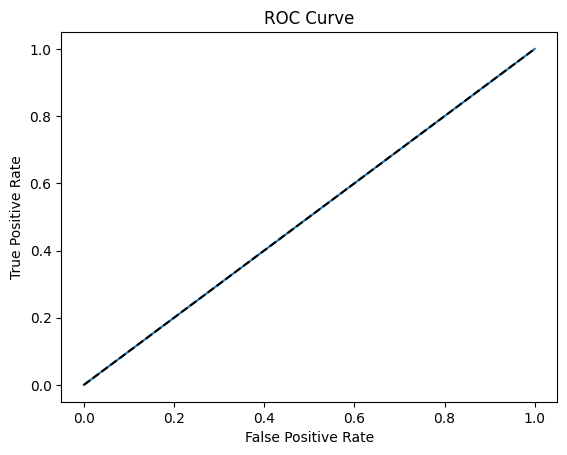

In [6]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_y, y_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [13]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

train_data = pd.read_csv("train_flooding_data.csv")
test_data = pd.read_csv("test_flooding_data.csv")

train_data.fillna(0)
train_data["ID"] = train_data["ID"].apply(lambda x: x.replace("id", ""))
test_data.fillna(0)
test_data["ID"] = test_data["ID"].apply(lambda x: x.replace("id", ""))

train_X = train_data.drop(columns=['Label']).values
train_y = train_data['Label'].values
test_X = test_data.drop(columns=['Label']).values
test_y = test_data['Label'].values

train_X = train_X.astype('float32')
train_y = train_y.astype('float32')
test_X = test_X.astype('float32')
test_y = test_y.astype('float32')

train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=256, step=32), 
                        input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])
    
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=3)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(train_X, train_y, epochs=2, batch_size=32, validation_data=(test_X, test_y), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

model.fit(train_X, train_y, epochs=2, batch_size=32, validation_data=(test_X, test_y))

score = model.evaluate(test_X, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score)

Trial 10 Complete [00h 11m 24s]
val_accuracy: 0.705369770526886

Best val_accuracy So Far: 0.705369770526886
Total elapsed time: 01h 19m 43s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2
64396/64396 [==============================] - 96s 1ms/step - loss: nan - accuracy: 0.6955 - val_loss: nan - val_accuracy: 0.7054
Epoch 2/2
64396/64396 [==============================] - 95s 1ms/step - loss: nan - accuracy: 0.6955 - val_loss: nan - val_accuracy: 0.7054
Test loss: nan
Test accuracy: [nan, 0.705369770526886]


Epoch 1/2
32198/32198 [==============================] - 57s 2ms/step - loss: nan - accuracy: 0.6955 - val_loss: nan - val_accuracy: 0.7054
Epoch 2/2
32198/32198 [==============================] - 54s 2ms/step - loss: nan - accuracy: 0.6955 - val_loss: nan - val_accuracy: 0.7054


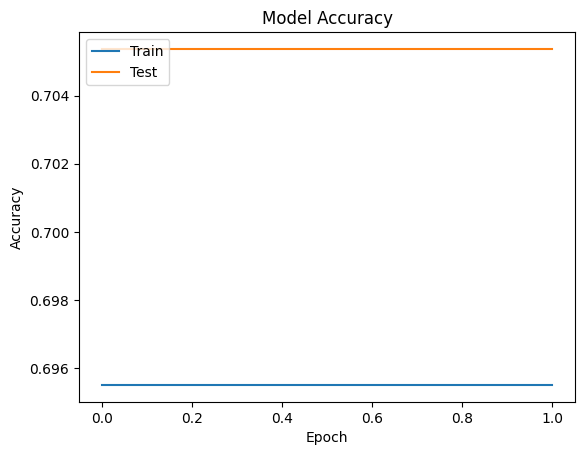

In [11]:
history = model.fit(train_X, train_y, batch_size=64, epochs=2, validation_data=(test_X, test_y))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

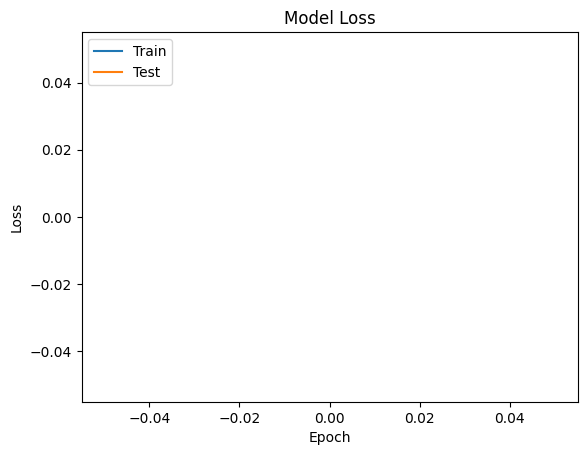

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

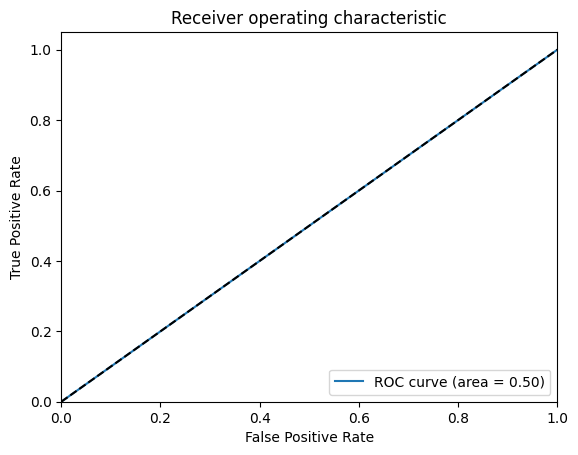

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

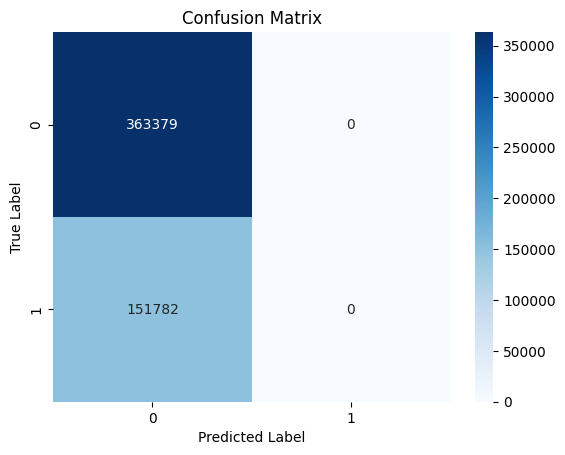

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_y, y_pred.round())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()